In [1]:
!pip install cxr-foundation



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\gebre\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:

from cxr_foundation.mimic import parse_embedding_file_pattern
from cxr_foundation import embeddings_data


In [3]:
import pandas as pd
from IPython.display import clear_output
import io
import os
import glob
import zipfile
import shutil

import numpy as np
import random as python_random
import matplotlib.pyplot as plt
from numpy import linalg as LA
import seaborn as sns
import sklearn.metrics as sklm
from sklearn.utils import shuffle

seed=19
np.random.seed(seed)
python_random.seed(seed)

In [ ]:
# path to the zip file
zip_file_path = "./Extracted_Embeddings/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0.zip"

# folder we want to extract the contents
extraction_folder = "./Extracted_Embeddings/"

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_folder)

print("Extraction complete.")

Extraction complete.


In [4]:
df_embeddings = pd.read_csv("./Extracted_Embeddings/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/SHA256SUMS.txt",
                            delimiter=" ", header=None,skiprows=[0])
display(df_embeddings.head(1))

,0,1
0,70e8c87d38d5dfba586218ccafb7428f76a3c7b08f6179...,files/p10/p10000032/s50414267/02aa804e-bde0afd...


In [5]:
SOURCE_COL_NAME = "embeddings_file"
# Create additional columns from file path components
df_embeddings = df_embeddings[[1]]
df_embeddings.rename(columns={1: "embeddings_file"}, inplace=True)
df_embeddings[["subject_id","study_id", "dicom_id"]] = df_embeddings.apply(
    lambda x: parse_embedding_file_pattern(x[SOURCE_COL_NAME]), axis=1, result_type="expand")
df_embeddings.embeddings_file="./Extracted_Embeddings/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/"+df_embeddings.embeddings_file
df_embeddings.head(2)

,embeddings_file,subject_id,study_id,dicom_id
0,./Extracted_Embeddings/generalized-image-embed...,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014
1,./Extracted_Embeddings/generalized-image-embed...,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab


In [12]:
df_embeddings.shape

(243324, 4)

In [6]:
example = embeddings_data.read_record_example(df_embeddings.embeddings_file.iloc[80000])
print(example)

features {
  feature {
    key: "image/id"
    value {
      bytes_list {
        value: "gs://superrad/inputs/mimic-cxr/files/p13/p13293446/s59443209/fab023c8-d71b0d99-29a6b65d-ef2c3103-d2de9e1a.dcm"
      }
    }
  }
  feature {
    key: "image/format"
    value {
      bytes_list {
        value: "png"
      }
    }
  }
  feature {
    key: "embedding"
    value {
      float_list {
        value: 0.138844699
        value: -0.451838
        value: 0.817155361
        value: -1.85264266
        value: -1.07941663
        value: -0.171157643
        value: 0.635435104
        value: 0.837272644
        value: -0.555685401
        value: 0.485173613
        value: -0.712232351
        value: -0.35557434
        value: -0.503891587
        value: 0.560500383
        value: 0.811845243
        value: 1.71060061
        value: -1.72992671
        value: 0.325764924
        value: 0.450283289
        value: 1.03946161
        value: 0.846848309
        value: 1.65851307
        value: -2.

## Embeddings Metadata

Data source:
- https://physionet.org/content/image-embeddings-mimic-cxr/1.0/
- https://physionet.org/content/mimiciv/1.0/
- https://physionet.org/content/mimic-cxr-jpg/2.0.0/


In [8]:
df_metadata = pd.read_csv("./Extracted_Embeddings/mimic-cxr-2.0.0-metadata.csv.gz", compression="gzip")
MIMIC_CXR_Labels_df = pd.read_csv("./Extracted_Embeddings/mimic-cxr-2.0.0-chexpert.csv.gz", compression="gzip")
demographic_df  = pd.read_csv("./Extracted_Embeddings/admissions.csv.gz", compression="gzip")
patients_df  = pd.read_csv("./Extracted_Embeddings/patients.csv.gz", compression="gzip")


In [9]:
df_metadata.info()
MIMIC_CXR_Labels_df.info()
demographic_df.info()
patients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377110 entries, 0 to 377109
Data columns (total 12 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   dicom_id                                    377110 non-null  object 
 1   subject_id                                  377110 non-null  int64  
 2   study_id                                    377110 non-null  int64  
 3   PerformedProcedureStepDescription           341598 non-null  object 
 4   ViewPosition                                361341 non-null  object 
 5   Rows                                        377110 non-null  int64  
 6   Columns                                     377110 non-null  int64  
 7   StudyDate                                   377110 non-null  int64  
 8   StudyTime                                   377110 non-null  float64
 9   ProcedureCodeSequence_CodeMeaning           377110 non-null  object 
 

In [10]:
df_metadata.head(2)

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,21800506,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,CHEST (PA AND LAT),LATERAL,3056,2544,21800506,213014.531,CHEST (PA AND LAT),lateral,Erect


In [11]:
demographic_df.insurance.value_counts()

insurance
Other       301530
Medicare    171360
Medicaid     50850
Name: count, dtype: int64

In [18]:
patients_df.shape

(382278, 6)

In [12]:
print(f'Number of records in chexpert labels before updating -1 and NAN values {len(MIMIC_CXR_Labels_df)} ')

Number of records in chexpert labels before updating -1 and NAN values 227827 


In [13]:
MIMIC_CXR_Labels_df.head(2)

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [14]:
MIMIC_CXR_Labels_df.replace(np.nan,0,inplace=True)
MIMIC_CXR_Labels_df.replace(-1,0,inplace=True)

MIMIC_CXR_Labels_df.shape

(227827, 16)

In [15]:
MIMIC_CXR_Labels_df.head(2)

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,10000032,53189527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Create the full labels file

Join embeddings list with Demography metadata files

In [16]:
demographic_df = demographic_df.drop_duplicates(subset='subject_id')
demographic_df.shape

(256878, 15)

In [24]:
demographic_df.ethnicity.value_counts()

ethnicity
WHITE                            159471
BLACK/AFRICAN AMERICAN            31190
ASIAN                             16526
UNKNOWN                           16464
OTHER                             15859
HISPANIC/LATINO                   13334
UNABLE TO OBTAIN                   3086
AMERICAN INDIAN/ALASKA NATIVE       948
Name: count, dtype: int64

In [17]:
# remove patients who have inconsistent documented race information
# credit to github.com/robintibor
ethnicity_df = demographic_df.loc[:,['subject_id', 'ethnicity']].drop_duplicates()
v = ethnicity_df.subject_id.value_counts()
subject_id_more_than_once = v.index[v.gt(1)]

print(f'count of duplicated subject id : {len(subject_id_more_than_once)}')

ambiguous_ethnicity_df = ethnicity_df[ethnicity_df.subject_id.isin(subject_id_more_than_once)]

inconsistent_race = ambiguous_ethnicity_df.subject_id.unique()

count of duplicated subject id : 0


In [18]:
data_df= df_metadata.merge(demographic_df,on='subject_id')
data_df.shape

(347747, 26)

In [19]:
# Each study contains one or more DICOMs
data_df = data_df.merge(patients_df, on=['subject_id'])

# Select only the columns you want to include
data_df=data_df.drop(columns=['anchor_year','anchor_year_group','dod','hadm_id', 'admittime','dischtime',
                              'deathtime','admission_type','admission_location','discharge_location'
                                ,'language','marital_status','edregtime','edouttime','hospital_expire_flag',
                                'PerformedProcedureStepDescription','ViewPosition','Rows','Columns',
                                'StudyDate','StudyTime','ProcedureCodeSequence_CodeMeaning',
                                'ViewCodeSequence_CodeMeaning','PatientOrientationCodeSequence_CodeMeaning'])
data_df.shape

(347747, 7)

In [20]:
data_df = data_df[~data_df.subject_id.isin(inconsistent_race)]
data_df = data_df.rename(columns={"ethnicity": "race"})
# Merge labelsdf based on (subject_id + study_id)
data_df = data_df.merge(MIMIC_CXR_Labels_df, on=['study_id','subject_id'])
data_df.shape


(347732, 21)

In [21]:

data_df = df_embeddings.merge(data_df, on=['dicom_id'], how='left')
data_df=data_df.loc[:, ~data_df.columns.duplicated()]
data_df.dropna(inplace=True)
data_df.rename(columns={'subject_id_x': 'subject_id','study_id_x': 'study_id'}, inplace=True)
data_df.shape

(228905, 24)

In [22]:

data_df=data_df[['embeddings_file','subject_id','study_id','dicom_id','gender','insurance',
                 'anchor_age','race','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity',
                 'Lung Lesion','Edema','Consolidation','Pneumonia','Atelectasis'
                 ,'Pneumothorax','Pleural Effusion','Pleural Other','Fracture'
                 ,'Support Devices','No Finding']]
data_df.insert(4, "split","none", True)
data_df.rename(columns={'embeddings_file': 'path'},inplace=True)
data_df.race.value_counts()

race
WHITE                            150364
BLACK/AFRICAN AMERICAN            36572
HISPANIC/LATINO                   12427
OTHER                             10726
UNKNOWN                            9844
ASIAN                              7390
UNABLE TO OBTAIN                    918
AMERICAN INDIAN/ALASKA NATIVE       664
Name: count, dtype: int64

In [23]:
data_df.isna().sum()


path                          0
subject_id                    0
study_id                      0
dicom_id                      0
split                         0
gender                        0
insurance                     0
anchor_age                    0
race                          0
Enlarged Cardiomediastinum    0
Cardiomegaly                  0
Lung Opacity                  0
Lung Lesion                   0
Edema                         0
Consolidation                 0
Pneumonia                     0
Atelectasis                   0
Pneumothorax                  0
Pleural Effusion              0
Pleural Other                 0
Fracture                      0
Support Devices               0
No Finding                    0
dtype: int64

In [24]:
data_df['anchor_age'] = data_df['anchor_age'].astype('int64')

data_df.insert(data_df.columns.get_loc('anchor_age') + 1, 'age_decile', None)

# Define custom bin edges and labels
bin_edges = [0, 20, 40, 60, 80, float('inf')]
bin_labels = ['0-20', '20-40', '40-60', '60-80', '80+']

# Use cut to create age deciles based on custom bins
data_df['age_decile'] = pd.cut(data_df['anchor_age'],
                                    bins=bin_edges, labels=bin_labels,
                                    right=False)
display(data_df.head(2))

,path,subject_id,study_id,dicom_id,split,gender,insurance,anchor_age,age_decile,race,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,./Extracted_Embeddings/generalized-image-embed...,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,none,F,Medicaid,52,40-60,WHITE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,./Extracted_Embeddings/generalized-image-embed...,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,none,F,Medicaid,52,40-60,WHITE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
data_df.drop(columns=['anchor_age'],inplace=True)

In [26]:
print(f'Number of records after merging meta data, diagnosticl labeles and vector embedings and removing duplicates {len(data_df)} ')

Number of records after merging meta data, diagnosticl labeles and vector embedings and removing duplicates 228905 


In [27]:
unique_sub_id = data_df.subject_id.unique()

train_percent, valid_percent, test_percent = 0.80, 0.10, 0.10

unique_sub_id = shuffle(unique_sub_id)
value1 = (round(len(unique_sub_id)*train_percent))
value2 = (round(len(unique_sub_id)*valid_percent))
value3 = value1 + value2
value4 = (round(len(unique_sub_id)*test_percent))


In [28]:
print("Patients in training set: " + str(value1))

Patients in training set: 42458


In [29]:
print("Patients in validation set: " + str(value2))

Patients in validation set: 5307


In [30]:
print("Patients in testing set: " + str(value4))

Patients in testing set: 5307


In [31]:
data_df = shuffle(data_df)

train_sub_id = unique_sub_id[:value1]
validate_sub_id = unique_sub_id[value1:value3]
test_sub_id = unique_sub_id[value3:]

print(type(train_sub_id))
print(train_sub_id)

<class 'numpy.ndarray'>
[14631209 12474949 17954787 ... 13961548 13378640 11011523]


In [32]:
data_df.loc[data_df.subject_id.isin(train_sub_id), "split"]="train"
data_df.loc[data_df.subject_id.isin(validate_sub_id), "split"]="validate"
data_df.loc[data_df.subject_id.isin(test_sub_id), "split"]="test"

In [33]:
data_df.split.value_counts()

split
train       182896
validate     23154
test         22855
Name: count, dtype: int64

In [34]:
data_df.shape

(228905, 23)

In [35]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228905 entries, 101426 to 127797
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   path                        228905 non-null  object  
 1   subject_id                  228905 non-null  int64   
 2   study_id                    228905 non-null  int64   
 3   dicom_id                    228905 non-null  object  
 4   split                       228905 non-null  object  
 5   gender                      228905 non-null  object  
 6   insurance                   228905 non-null  object  
 7   age_decile                  228905 non-null  category
 8   race                        228905 non-null  object  
 9   Enlarged Cardiomediastinum  228905 non-null  float64 
 10  Cardiomegaly                228905 non-null  float64 
 11  Lung Opacity                228905 non-null  float64 
 12  Lung Lesion                 228905 non-null  float64 
 13 

In [36]:
# Generic path
data_df['path'] = data_df['path'].str.replace(r'^./Extracted_Embeddings/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/', '', regex=True)


In [37]:
data_df.head(2)

,path,subject_id,study_id,dicom_id,split,gender,insurance,age_decile,race,Enlarged Cardiomediastinum,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
101426,files/p14/p14174495/s51234155/2404c1ab-a3b40cd...,14174495,51234155,2404c1ab-a3b40cde-0c825331-769edf1e-2d99b2cf,train,M,Medicare,60-80,WHITE,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
71754,files/p12/p12958709/s57422323/cc870a3a-f53f453...,12958709,57422323,cc870a3a-f53f453b-2ac5395a-ac1794e8-e0c0bba8,train,F,Other,20-40,HISPANIC/LATINO,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:
data_df.to_csv("./Extracted_Embeddings/processed_mimic_df.csv",index=False)

In [39]:
df_train = data_df[data_df["split"] == "train"]
df_train.to_csv("./Extracted_Embeddings/mimic_train_df.csv",index=False)

In [40]:
df_train.shape

(182896, 23)

In [41]:
df_validate = data_df[data_df["split"] == "validate"]
df_validate.to_csv("./Extracted_Embeddings/mimic_validation_df.csv",index=False)

In [42]:
df_test = data_df[data_df["split"] == "test"]
df_test.shape

(22855, 23)

In [43]:
df_test=df_test[df_test.race.isin(['WHITE','BLACK/AFRICAN AMERICAN','HISPANIC/LATINO','OTHER',
                                   'ASIAN','AMERICAN INDIAN/ALASKA NATIVE'])]
df_test.shape

(21591, 23)

In [44]:
df_test.race.value_counts()

race
WHITE                            14508
BLACK/AFRICAN AMERICAN            3685
HISPANIC/LATINO                   1392
OTHER                             1062
ASIAN                              760
AMERICAN INDIAN/ALASKA NATIVE      184
Name: count, dtype: int64

In [45]:
test_counts=df_test.subject_id.unique()
len(test_counts)

5109

In [46]:
df_test.to_csv("./Extracted_Embeddings/mimic_test_df.csv",index=False)

In [47]:
data_df=pd.concat([df_train,df_validate,df_test],axis=0)
data_df.shape

(227641, 23)

In [63]:
data_df["race"].replace({"WHITE": "White","BLACK/AFRICAN AMERICAN": "Black",
                                   "HISPANIC/LATINO": "Hisp","OTHER": "Other","UNKNOWN": "Other",
                                   "UNABLE TO OBTAIN": "Other","AMERICAN INDIAN/ALASKA NATIVE": "Native",
                                   "ASIAN": "Asian"}, inplace=True)

C:\Users\gebre\AppData\Local\Temp\ipykernel_14540\1796893976.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df["race"].replace({"WHITE": "White","BLACK/AFRICAN AMERICAN": "Black",


In [64]:
data_df.race.value_counts()

race
White     150364
Black      36572
Other      20224
Hisp       12427
Asian       7390
Native       664
Name: count, dtype: int64

C:\Users\gebre\AppData\Local\Temp\ipykernel_14540\2512602569.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, ax=axs[0, 0], palette='Blues_d')
C:\Users\gebre\AppData\Local\Temp\ipykernel_14540\2512602569.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data_df['age_decile'], bins=len(data_df['age_decile'].unique()), ax=axs[0, 1], palette='pastel')
C:\Users\gebre\AppData\Local\Temp\ipykernel_14540\2512602569.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_df, x='race', ax=axs[1, 1], palette='pastel')


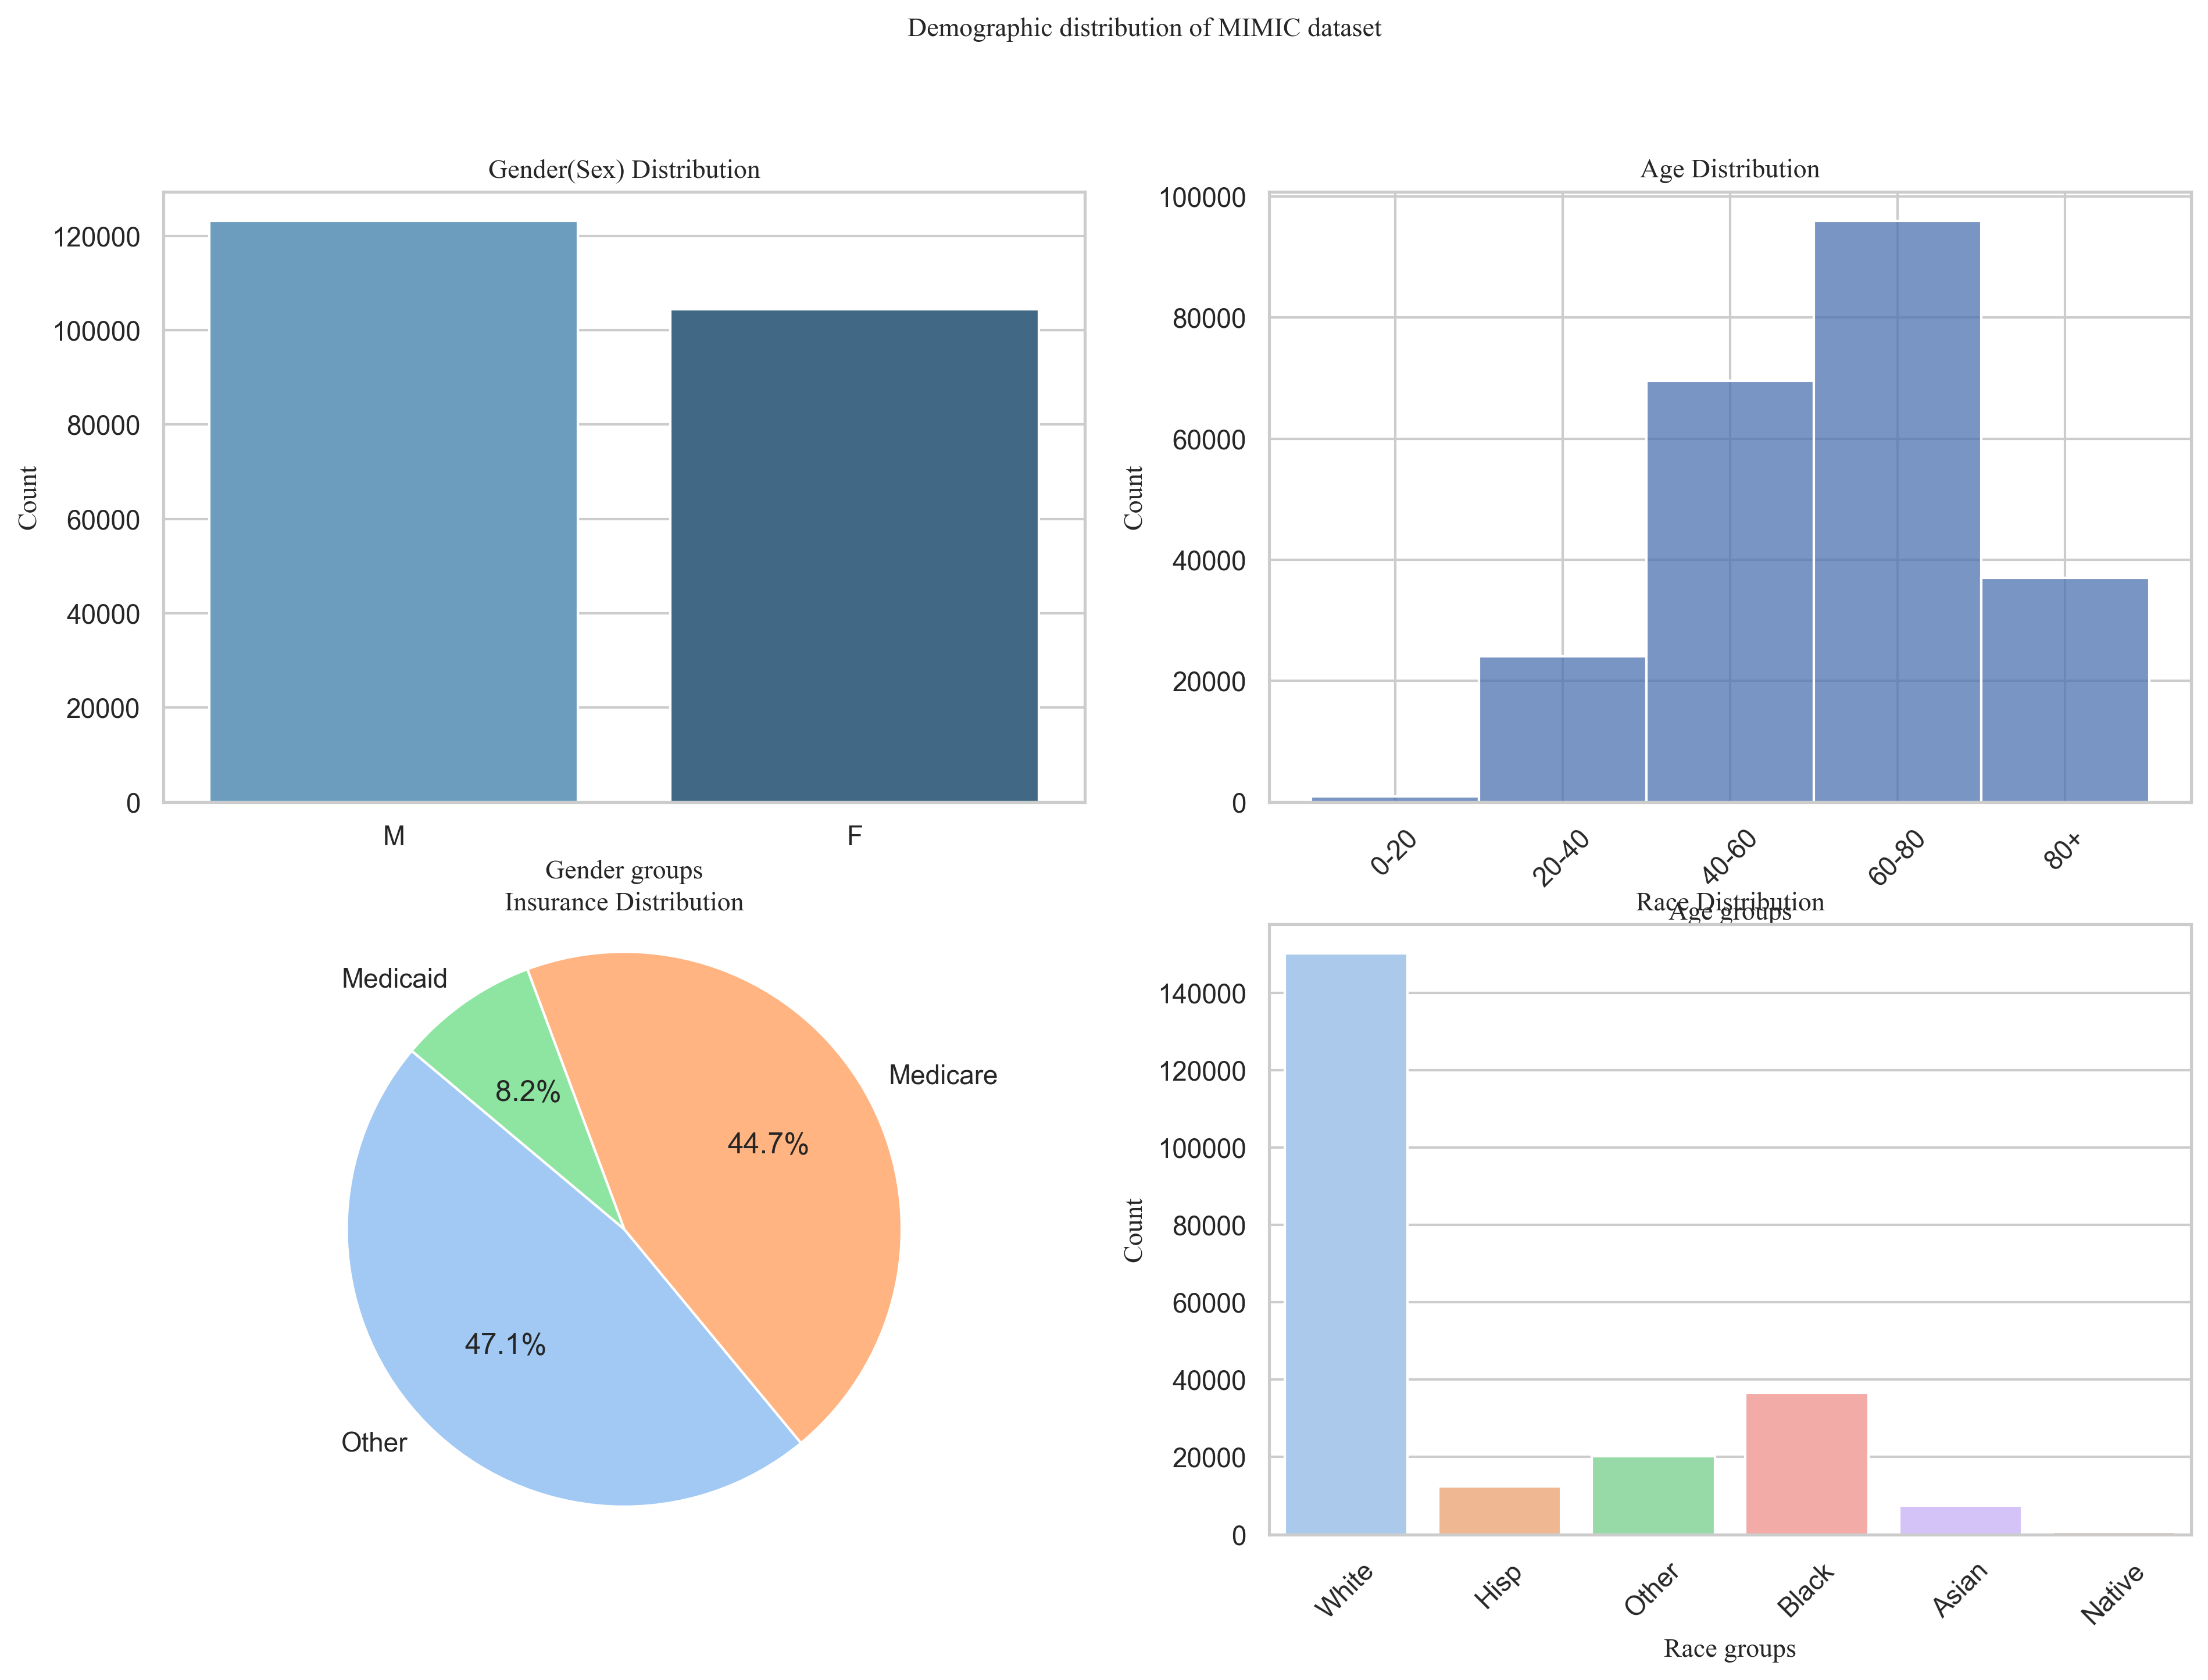

In [78]:
font_name='Times New Roman'
fontsize=11


# Set Seaborn style
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(15,10), dpi=300)

# Gender (Bar Plot)
gender_counts = data_df.gender.value_counts()
sns.barplot(x=gender_counts.index, y=gender_counts.values, ax=axs[0, 0], palette='Blues_d')
axs[0, 0].set_title('Gender(Sex) Distribution', fontsize=fontsize, fontname=font_name)
axs[0, 0].set_xlabel('Gender groups', fontsize=fontsize, fontname=font_name)
axs[0, 0].set_ylabel('Count',fontsize=fontsize, fontname=font_name)

# Age (Histogram)
sns.histplot(data_df['age_decile'], bins=len(data_df['age_decile'].unique()), ax=axs[0, 1], palette='pastel')
axs[0, 1].set_title('Age Distribution',fontsize=fontsize, fontname=font_name)
axs[0, 1].set_xlabel('Age groups',fontsize=fontsize, fontname=font_name)
axs[0, 1].set_ylabel('Count',fontsize=fontsize, fontname=font_name)
axs[0, 1].tick_params(axis='x', rotation=45)

# Insurance (Pie Chart)
insurance_counts = data_df.insurance.value_counts()
axs[1, 0].pie(insurance_counts, labels=insurance_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
axs[1, 0].set_title('Insurance Distribution',fontsize=fontsize, fontname=font_name)
axs[1, 0].axis('equal')

# Race (Count Plot)
sns.countplot(data=data_df, x='race', ax=axs[1, 1], palette='pastel')
axs[1, 1].set_title('Race Distribution',fontsize=fontsize, fontname=font_name)
axs[1, 1].set_xlabel('Race groups',fontsize=fontsize, fontname=font_name)
axs[1, 1].set_ylabel('Count',fontsize=fontsize, fontname=font_name)
axs[1, 1].tick_params(axis='x', rotation=45)

fig.suptitle('Demographic distribution of MIMIC dataset',fontsize=fontsize,fontname=font_name)

# Adjust layout
plt.savefig('./demographic_distributions_MIMIC.pdf',bbox_inches='tight')
